# Bayesian Coin Flips

Bayesian statistics provides a framework for updating beliefs based on new evidence.  
Let's use coin flips to illustrate how Bayesian inference works.

Imagine we have a coin, but we don’t know if it’s fair or biased.  
We want to estimate the probability $p$ that the coin lands heads up. 

In [1]:
# Numerical arrays.
import numpy as np

# Plots.
import matplotlib.pyplot as plt

# Statistical distributions.
import scipy.stats as stats

# Bayesian statistics.
import pymc

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Plotting Values

In [2]:
# Plotting
x = np.linspace(0, 1, 1000)  # Values of p from 0 to 1

## Prior Belief

In Bayesian statistics, we start with a **prior belief** about $p$, the probability of heads.  
This belief can be based on past knowledge, intuition, or be vague.  

For simplicity, let’s assume we don't know much about the coin.  
Then we use a **uniform prior** over $p$.  
This means we believe that any probability between 0 and 1 is equally likely.  

$P(p) = 1 \quad \text{for} \, 0 \leq p \leq 1$

This is our prior distribution.

In [3]:
# Data: 10 flips, 7 heads
n = 10  # Total flips
k = 7   # Heads observed

# Prior: Uniform distribution (Beta(1, 1))
a_prior, b_prior = 1, 1

# Prior distribution (Beta(1, 1))
prior = stats.beta.pdf(x, a_prior, b_prior)

## Likelihood

Suppose we flip the coin $n$ times and observe $k$ heads.  
The likelihood function represents the probability of seeing $k$ heads out of $n$ flips, given $p$.  

This follows a binomial distribution:  

$P(\text{data} \mid p) = \binom{n}{k} p^k (1 - p)^{n - k}$  

This is the likelihood of observing the data (number of heads) given the parameter $p$.



## Posterior Distribution

Using Bayes' Theorem, we update our belief about $p$ after observing the data.  
Bayes' Theorem is:  

$P(p \mid \text{data}) = \frac{P(\text{data} \mid p) P(p)}{P(\text{data})}$

Where:  

- $P(p \mid \text{data})$ is the **posterior distribution**, which represents our updated belief about $p$ after seeing the data.

- $P(\text{data} \mid p)$ is the **likelihood**, which we just defined.

- $P(p)$ is the **prior**.

- $P(\text{data})$ is the **evidence**, a normalizing constant that ensures the posterior is a valid probability distribution.


Since the evidence is just a constant and doesn't affect the shape of the posterior, we focus on the numerator:  
$P(p \mid \text{data}) \propto P(\text{data} \mid p) P(p)$

For our example with a uniform prior, the posterior simplifies to:  
$P(p \mid \text{data}) \propto p^k (1 - p)^{n - k}$

This is a **Beta distribution**, specifically:  
$P(p \mid \text{data}) \sim \text{Beta}(k + 1, n - k + 1)$  

The Beta distribution is the conjugate prior for the binomial distribution, meaning that if you start with a Beta prior, the posterior will also be Beta.



In [4]:
# Posterior: Beta(k + a_prior, n - k + b_prior)
a_post = k + a_prior
b_post = n - k + b_prior

# Posterior distribution (Beta(k + 1, n - k + 1))
posterior = stats.beta.pdf(x, a_post, b_post)

## Interpretation

Before observing any flips, we had no preference for any particular value of $p$ (uniform prior).  

After observing $k$ heads and $n-k$ tails, the posterior distribution represents our updated belief about $p$.  
The more flips we observe, the more confident we become about the true value of $p$.  

For example, if you observe 7 heads out of 10 flips, the posterior would be $\text{Beta}(8, 4)$.  
This distribution peaks around $p = 0.7$, reflecting our updated belief that the coin might be biased toward heads.

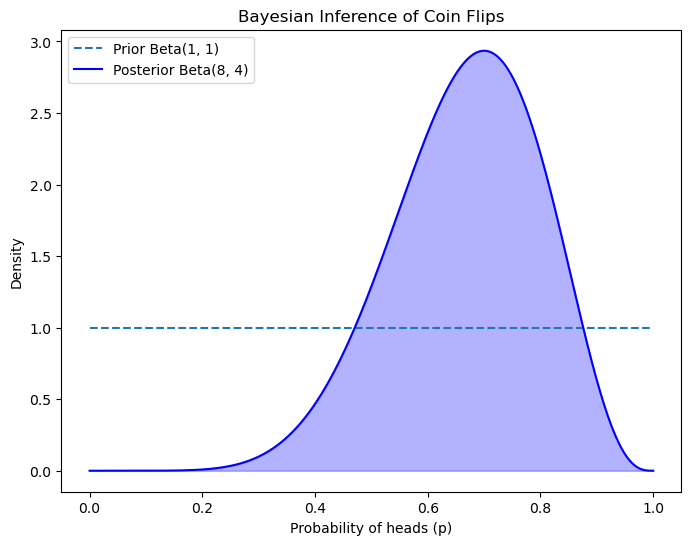

In [5]:
# Plot prior and posterior
plt.figure(figsize=(8, 6))
plt.plot(x, prior, label=f'Prior Beta({a_prior}, {b_prior})', linestyle='--')
plt.plot(x, posterior, label=f'Posterior Beta({a_post}, {b_post})', color='blue')
plt.fill_between(x, posterior, alpha=0.3, color='blue')

plt.title('Bayesian Inference of Coin Flips')
plt.xlabel('Probability of heads (p)')
plt.ylabel('Density')
plt.legend()
plt.show()

## Explanation of the Code:

1. **Data**: We have 10 flips and observed 7 heads.

2. **Prior**: We assume a uniform prior, which is equivalent to a `Beta(1, 1)` distribution.

3. **Posterior**: The posterior after observing 7 heads out of 10 flips is `Beta(8, 4)`.

4. **Plotting**: We plot both the prior and the posterior to visualize how the prior belief is updated by the data.


### Expected Output:

- The prior will be a flat line since we assumed all values of $p$ are equally likely (uniform distribution).

- The posterior will peak around $p$, reflecting the fact that we observed 7 heads in 10 flips.

## Bayesian Inference in Practice

1. **Start with a prior**: Your initial belief about the parameter (e.g., $p$).

2. **Collect data**: Flip the coin several times.

3. **Update your prior**: Use the likelihood of the data to update your prior, resulting in a posterior distribution.

4. **Make decisions**: Use the posterior distribution to make probabilistic statements about $p$ or to predict future outcomes.



## Beta Examples

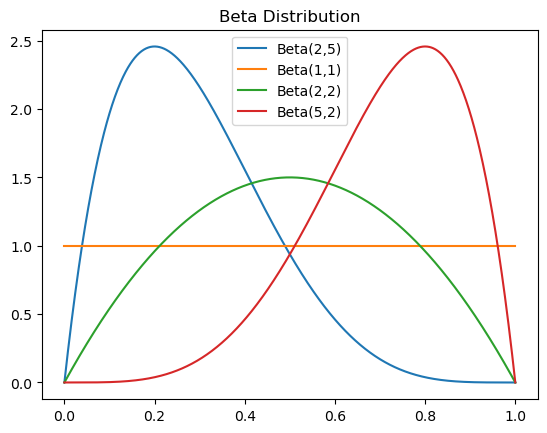

In [6]:
# Plot the Beta distribution for various values of a and b.
for a, b in [(2, 5), (1, 1), (2, 2), (5, 2)]:
    y = stats.beta.pdf(x, a, b)
    plt.plot(x, y, label=f'Beta({a},{b})')

# Title.
plt.title('Beta Distribution')
plt.legend()

## PyMC

In [7]:


# Data: 10 flips, 7 heads
n = 10  # Total flips
k = 7   # Heads observed

# Bayesian model using PyMC
with pm.Model() as model:
    # Prior: Uniform distribution for the probability of heads
    p = pm.Beta('p', alpha=1, beta=1)
    
    # Likelihood: Binomial likelihood based on observed data (k heads out of n flips)
    obs = pm.Binomial('obs', n=n, p=p, observed=k)
    
    # Inference: Perform sampling to estimate the posterior distribution
    trace = pm.sample(1000, return_inferencedata=False, progressbar=False)

# Posterior distribution
posterior_samples = trace['p']

# Plot posterior distribution
plt.figure(figsize=(8, 6))
plt.hist(posterior_samples, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Posterior distribution of probability of heads (p)')
plt.xlabel('p (probability of heads)')
plt.ylabel('Density')
plt.show()


NameError: name 'pm' is not defined

## Summary

In Bayesian statistics:  

- You **start with a prior** belief.

- You **update this belief** with new evidence (coin flips) using Bayes' Theorem.

- The result is a **posterior distribution**, representing your new belief about the probability of heads.


This framework is powerful because it continuously updates with more data, allowing you to refine your estimate of $p$.

## End